# 01 Trefor park

In [1]:
import torch
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_every_model
from core.util.save_model import load_model, load_parameters
from core.util.get_datasets import split_data, denormalize_data
from core.util.trefor_dataset import TreforData
from core.models import LSTM, GRU, CNNLSTM
from core.models.model_training import test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
import numpy as np
import pandas as pd
from core.util.metrics import mae, rmse, smape, adjusted_smape

## Configuration
Parameters specific to this experiment

If the host has CUDA, it will use the GPU for computation

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Change these
Specify the features for this experiment, the best models and the experiment number.

In [3]:
features = {
    "Month_x": True,
    "Month_y": True,
    "Hour_x": True,
    "Hour_y": True,
    "Day_x": True,
    "Day_y": True,
}
experiment_no = 1

In [4]:
params = {
    m: load_parameters(f"{experiment_no:02}_{m}_trefor_park")
    for m in ["LSTM", "GRU", "CNN_LSTM"]
}

best_models = {
    "LSTM": load_model(LSTM, f"{experiment_no:02}_LSTM_trefor_park", device),
    "GRU": load_model(GRU, f"{experiment_no:02}_GRU_trefor_park", device),
    "CNN_LSTM": load_model(CNNLSTM, f"{experiment_no:02}_CNN_LSTM_trefor_park", device),
}

Global hyperparameter configuration

In [5]:
hyperparameters = get_hyperparameter_configuration()
loss_function = hyperparameters["loss_function"]
horizon = hyperparameters["horizon"]
train_days = hyperparameters["train_days"]
val_days = hyperparameters["val_days"]
test_days = hyperparameters["test_days"]
lookback = 96

### Main loop
Iterate all hyperparameter configuration to find the best one.

For each of these, we do the full iteration of epochs (unless early stop occurs) with training and validation.
Lastly, we run the test set on the given model to see how it performs using the metrics MAE, RMSE, and sMAPE.

In [6]:
_, _, _, _, x_test, y_test = split_data(
    lookback=lookback,
    horizon=horizon,
    train_days=train_days,
    val_days=val_days,
    test_days=test_days,
    features=features,
)

results = {}

# x-values for naive baseline regression
# naive baseline is always 96 lookback window
x = np.arange(96) - 96

# iterate testset
naive_prediction = []
for item in x_test:
    # check the entire lookback window, but only get the consumption
    coef = np.polyfit(x, item[:, -1], 1)
    regression_fn = np.poly1d(coef)
    naive_prediction.append(regression_fn(np.arange(24)))
naive_prediction = denormalize_data(naive_prediction)

lagged_prediction = denormalize_data([item[-24:, -1] for item in x_test])

# test each model
for name, model in best_models.items():
    lb = params[name]["lookback"]
    lookback_specific_x = x_test[:, -lb:, :]
    test_dataset = TreforData(lookback_specific_x, y_test, device)

    testing_loader = DataLoader(
        test_dataset, batch_size=params[name]["batch_size"], shuffle=False
    )
    _, predicted = test_model(
        best_model=model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )
    results[name] = denormalize_data(predicted)

In order to select the second best model we sort the results by lowest sMAPE.

sMAPE is the chosen metric as the loss is lower when predictions are larger than the actual value compared to when predictions are lower than the actual value.
$$\hat{y} > y: \text{lower loss} \\ \hat{y} < y: \text{greater loss}$$

## Plotting

### Predictions- and actual consumption

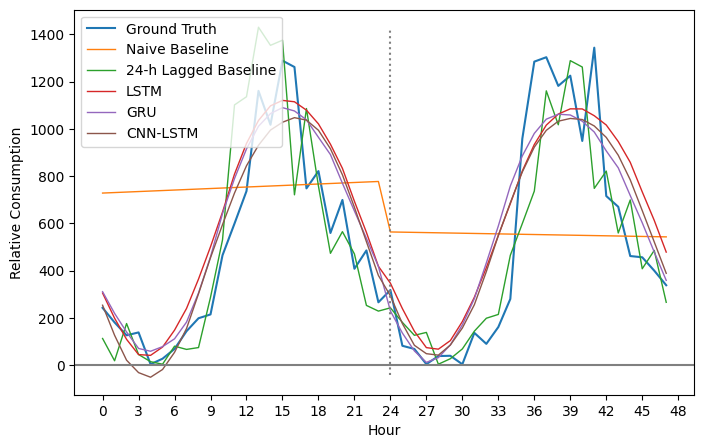

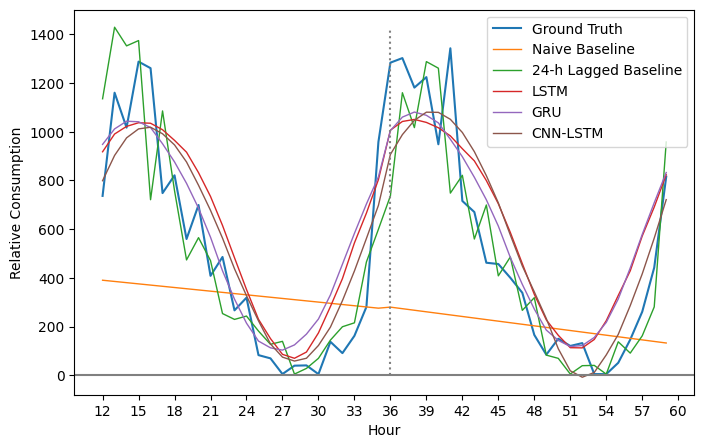

In [7]:
y_test = denormalize_data(y_test)
plot_every_model(
    200,
    202,
    y_test,
    naive_prediction,
    lagged_prediction,
    *results.values(),
    f"{experiment_no:02}.svg",
)

plot_every_model(
    200,
    202,
    y_test,
    naive_prediction,
    lagged_prediction,
    *results.values(),
    f"{experiment_no:02}_12-offset.svg",
    12,
)

## Loss for 48 hour period (one block)

In [8]:
start = 200
end = 202
y_test_period = y_test[start * 24 : end * 24].flatten()


models = {
    "LSTM": results["LSTM"][start * 24 : end * 24].flatten(),
    "GRU": results["GRU"][start * 24 : end * 24].flatten(),
    "CNN-LSTM": results["CNN_LSTM"][start * 24 : end * 24].flatten(),
}

loss = {}
for name, block in models.items():
    loss[name] = [
        mae(y_test_period, block).item(),
        rmse(y_test_period, block),
        smape(y_test_period, block).item(),
        adjusted_smape(y_test_period, block).item(),
    ]

pd.DataFrame(loss, index=["MAE", "RMSE", "sMAPE", "sMAPE w/o 0.05 lower bound"])

,LSTM,GRU,CNN-LSTM
MAE,189.019485,169.170120,166.846634
RMSE,219.767203,209.698721,201.601629
sMAPE,57.640705,52.893177,52.390377
sMAPE w/o 0.05 lower bound,57.640705,52.893177,52.390377
